In [6]:
import os
from glob import glob
import itk
import vtk
from vtk import vtkCommand
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
DICOM_PATH = "/Users/benjaminhon/Developer/HeadHunter/notebooks/220259"
NII_PATH = "/Users/benjaminhon/Developer/HeadHunter/notebooks/220259.nii"
TUMOR_1 = glob("/Users/benjaminhon/Developer/HeadHunter/notebooks/masks/tumor1/*.png")
TUMOR_2 = glob("/Users/benjaminhon/Developer/HeadHunter/notebooks/masks/tumor2/*.png")
SPECIMEN = glob("/Users/benjaminhon/Developer/HeadHunter/notebooks/specimen/*")
SLICE = 7
BACKGROUND = 0.2

# ITK Types

In [8]:
IF3 = itk.Image[itk.F, 3]
IUC3 = itk.Image[itk.UC, 3]
IRGBUC3 = itk.Image[itk.RGBPixel[itk.UC], 3]
LMLOUL3 = itk.LabelMap[itk.StatisticsLabelObject[itk.UL, 3]]

# Read NII and convert to numpy array

In [9]:
niiFileReader = itk.ImageSeriesReader[IF3].New()
niiFileReader.SetFileNames(TUMOR_1)
niiFileReader.Update()
tumor1Arr = itk.GetArrayFromImage(niiFileReader.GetOutput())
niiFileReader.SetFileNames(TUMOR_2)
niiFileReader.Update()
tumor2Arr = itk.GetArrayFromImage(niiFileReader.GetOutput())
backgroundArr = np.full(tumor1Arr.shape, BACKGROUND)

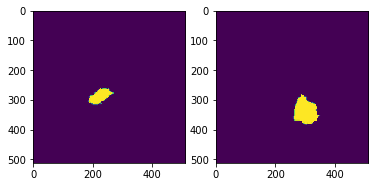

In [10]:
plt.subplot(1, 2, 1)
plt.imshow(tumor1Arr[6])
plt.subplot(1, 2, 2)
plt.imshow(tumor2Arr[6])

# ArgMax

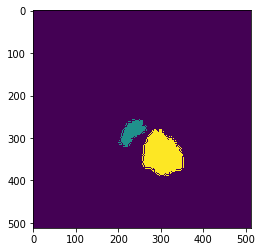

In [23]:
argMax = np.argmax([backgroundArr] + [tumor1Arr, tumor2Arr], axis=0).astype(np.uint8)
plt.imshow(argMax[SLICE])
# [backgroundArr, tumor1Arr, tumor2Arr]
# [backgroundArr] + [tumor1Arr, tumor2Arr] # this is correct !
# backgroundArr + [tumor1Arr, tumor2Arr] # this is wrong !

# To ITK Labels

In [24]:
segmentationImage = itk.GetImageFromArray(argMax)

# Specimen DICOM

In [27]:
def generateSeries(path):
    generator = itk.GDCMSeriesFileNames.New()
    generator.SetDirectory(path)
    seriesUIDs = generator.GetSeriesUIDs()
    series = { uid: generator.GetFileNames(uid) for uid in generator.GetSeriesUIDs() }
    return (series, seriesUIDs)

(series, seriesUIDs) = generateSeries(DICOM_PATH)
                
imageSeriesReader = itk.ImageSeriesReader[IF3].New()
imageSeriesReader.SetFileNames(series[seriesUIDs[2]])
imageSeriesReader.Update()

rescaleIntensityImageFilter = itk.RescaleIntensityImageFilter[IF3, IF3].New()
rescaleIntensityImageFilter.SetInput(imageSeriesReader.GetOutput())
rescaleIntensityImageFilter.SetOutputMaximum(255)
rescaleIntensityImageFilter.SetOutputMinimum(0)

castImageFilter = itk.CastImageFilter[IF3, IUC3].New()
castImageFilter.SetInput(rescaleIntensityImageFilter.GetOutput())
castImageFilter.Update()

# Resample labels to DICOM

In [28]:
# Set Reference Origin, Spacing, Direction
changeInformationImageFilter = itk.ChangeInformationImageFilter[IUC3].New()
changeInformationImageFilter.SetInput(segmentationImage)
changeInformationImageFilter.UseReferenceImageOn()
changeInformationImageFilter.ChangeDirectionOn()
changeInformationImageFilter.ChangeSpacingOn()
changeInformationImageFilter.ChangeOriginOn()
changeInformationImageFilter.SetReferenceImage(castImageFilter.GetOutput())

# Resample Labels to match DICOM
resampleImageFilter = itk.ResampleImageFilter[IUC3, IUC3].New()
resampleImageFilter.SetInput(changeInformationImageFilter.GetOutput())
resampleImageFilter.SetTransform(itk.IdentityTransform[itk.D, 3].New())
resampleImageFilter.SetInterpolator(itk.NearestNeighborInterpolateImageFunction[IUC3, itk.D].New())
resampleImageFilter.UseReferenceImageOn()
resampleImageFilter.SetReferenceImage(imageSeriesReader.GetOutput())
labelImageToLabelMapFilter = itk.LabelImageToLabelMapFilter[IUC3, LMLOUL3].New()
labelImageToLabelMapFilter.SetInput(resampleImageFilter.GetOutput())

# Overlay

In [29]:
labelMapOverlayImageFilter = itk.LabelMapOverlayImageFilter[LMLOUL3, IUC3, IRGBUC3].New()
labelMapOverlayImageFilter.SetInput(labelImageToLabelMapFilter.GetOutput())
labelMapOverlayImageFilter.SetFeatureImage(castImageFilter.GetOutput())
labelMapOverlayImageFilter.SetOpacity( 0.5 )
labelMapOverlayImageFilter.Update()

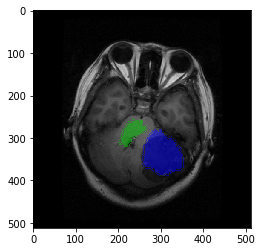

In [34]:
overlay = itk.GetArrayFromImage(labelMapOverlayImageFilter.GetOutput())
plt.imshow(overlay[SLICE])

In [ ]:
itk.ChangeInformationImageFilter.